# Testing the Method on SANS-2D Data

## Setup

In [1]:
import numpy as np
import scipp as sc
import sciline
import scippneutron as scn
import plopp as pp
import esssans as sans
from esssans.types import *

import matplotlib.pyplot as plt

In [2]:
pipeline = sciline.Pipeline(
    sans.providers + sans.sans2d.providers,
    params=sans.sans2d.default_parameters,
)

In [3]:
pipeline[FileList[BackgroundRun]] = ['SANS2D00063159.hdf5']
pipeline.insert(sans.transmission_from_background_run)
pipeline[FileList[SampleRun]] = ['SANS2D00063114.hdf5']
pipeline.insert(sans.transmission_from_sample_run)
pipeline[FileList[EmptyBeamRun]] = ['SANS2D00063091.hdf5']
pipeline[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.hdf5'
pipeline[OutFilename] = 'reduced.nxs'

pipeline[WavelengthBins] = sc.linspace(
    'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
)

pipeline[sans.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')

mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
pipeline[WavelengthMask] = sc.DataArray(
    sc.array(dims=['wavelength'], values=[True]),
    coords={'wavelength': mask_interval},
)

pipeline[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
pipeline[NonBackgroundWavelengthRange] = sc.array(
    dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
)
pipeline[CorrectForGravity] = True
pipeline[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
pipeline[sans.ReturnEvents] = True

## Explore the BackgroundSubtractedIofQ Output

This item apparently returns events.  Does it?  Examining this workflow it looks like it returns histogrammed data.  Examining the data in the output confirms this.

In [4]:
iofq = pipeline.get(BackgroundSubtractedIofQ)

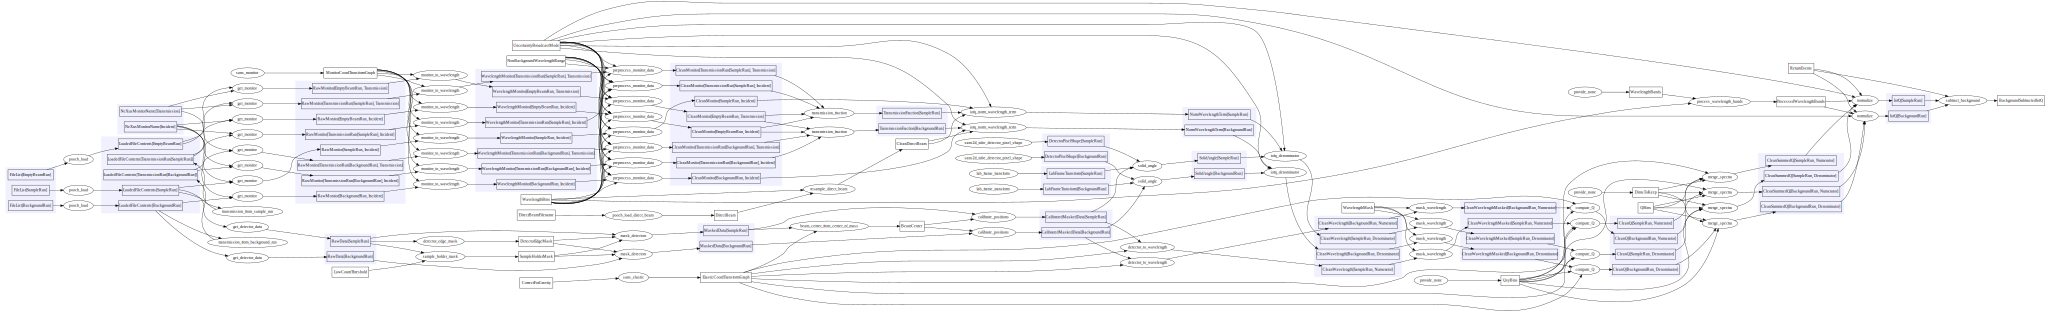

In [5]:
iofq.visualize(graph_attr={'rankdir': 'LR'})

In [6]:
sampiq = pipeline.get(BackgroundSubtractedIofQ)
sampres = sampiq.compute()

An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


### Initial exploration (not important)

In [7]:
print(sampres)

<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                          DataArrayView        <no unit>  (Q)  binned data: dim='event', content=DataArray(
          dims=(event: 6172466),
          data=float64[dimensionless],
          coords={'tof':float64[µs], 'pulse_time':datetime64[ns], 'wavelength':float64[Å],
                  'phi':float64[rad], 'Q':float64[1/Å]})




Note that the Q coords are bin edges, and the DataArrayView is "binned data".

Looking down at the data itself: 

In [8]:
svar = sampres.data
print(svar)

<scipp.Variable> (Q: 140)  DataArrayView        <no unit>  binned data: dim='event', content=DataArray(
          dims=(event: 6172466),
          data=float64[dimensionless],
          coords={'tof':float64[µs], 'pulse_time':datetime64[ns], 'wavelength':float64[Å],
                  'phi':float64[rad], 'Q':float64[1/Å]})


* We have there 140 Q values.
* It has no units
* but 6M events, and coords there has Q.  What is that?

In [9]:
sc.show(svar)

In [10]:
sc.show(svar[139])

In [11]:
sc.show(svar[0].values)

In [12]:
sc.show(svar[0].values.data)

In [13]:
print(svar[0].values.data[0])
print(svar[0].values.data[20000])

<scipp.Variable> ()    float64  [dimensionless]  0.003432  3.303e-05
<scipp.Variable> ()    float64  [dimensionless]  0.003432  3.303e-05


That's the Q value and the weight as a pair?
However, these data values are all the same within each bin?

In [12]:
# Simon Heybrock suggested this to extract the events:
print(sampres[0].value)
sc.show(sampres[0].value)

<scipp.DataArray>
Dimensions: Sizes[event:22015, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.014073, 0.0141408, ..., 0.0128737, 0.0141552]
* phi                       float64            [rad]  (event)  [-1.48244, -1.46791, ..., 1.27805, 1.638]
* pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:49:47.788024902, 2020-02-12T20:59:54.286010742, ..., 2020-02-14T05:38:44.839996337, 2020-02-14T05:56:34.838012695]
* tof                       float64            [µs]  (event)  [92788.1, 92477.4, ..., 85109, 79565.4]
* wavelength                float64             [Å]  (event)  [15.7654, 15.7126, ..., 14.4611, 13.5191]
Data:
                            float64  [dimensionless]  (event)  [0.003432, 0.003432, ..., -0.00235922, -0.00235922]  [3.303e-05, 3.303e-05, ..., 5.94507e-06, 5.94507e-06]




In [13]:
print(sampres[0].value[0])

<scipp.DataArray>
Dimensions: Sizes[]
Coordinates:
  Q                         float64           [1/Å]  ()  0.014073
  phi                       float64            [rad]  ()  -1.48244
  pulse_time              datetime64             [ns]  ()  2020-02-12T20:49:47.788024902
  tof                       float64            [µs]  ()  92788.1
  wavelength                float64             [Å]  ()  15.7654
Data:
                            float64  [dimensionless]  ()  0.003432  3.303e-05




In [14]:
print(sampres[0].value[0].coords['Q'].value) # The q value of the point
print(sampres[0].value[0].data.value) # the statistical weight?

0.014072992128883214
0.003431999959142457


## Continuing...

In [7]:
allevents = sampres.bins.concat().value
print(allevents)

<scipp.DataArray>
Dimensions: Sizes[event:6172466, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.014073, 0.0141408, ..., 0.593805, 0.594188]
* phi                       float64            [rad]  (event)  [-1.48244, -1.46791, ..., 2.41065, 2.3946]
* pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:49:47.788024902, 2020-02-12T20:59:54.286010742, ..., 2020-02-12T21:03:12.386108398, 2020-02-12T20:38:54.589000701]
* tof                       float64            [µs]  (event)  [92788.1, 92477.4, ..., 11876.9, 11848.4]
* wavelength                float64             [Å]  (event)  [15.7654, 15.7126, ..., 2.01191, 2.0071]
Data:
                            float64  [dimensionless]  (event)  [0.003432, 0.003432, ..., 3.58915, 3.58915]  [3.303e-05, 3.303e-05, ..., 19.0887, 19.0887]




In [8]:
eventQ = allevents.coords['Q'].values
eventW = allevents.values
nans = np.isnan(eventW)
print(nans)
eventW[nans] = 0.0
print(eventW)

[False False False ... False False False]
[ 3.43199996e-03  3.43199996e-03  3.43199996e-03 ... -1.63057064e+00
  3.58914659e+00  3.58914659e+00]


140
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [70.3897, 72.4561, ..., 7.17829, 0]  [0.702995, 0.463153, ..., 38.1775, 0]




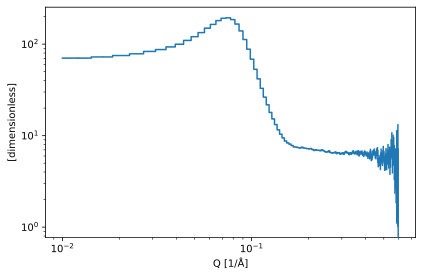

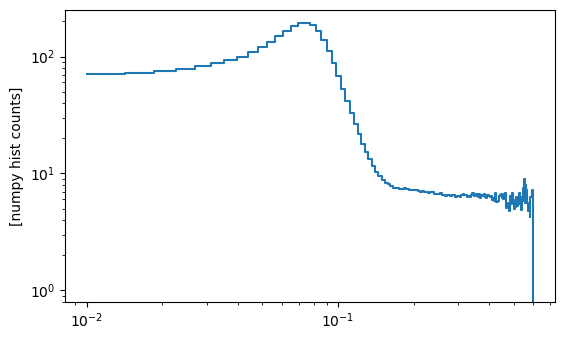

In [9]:
shst = sampres.hist()
print(shst.size)
print(shst)

scipp_bins = shst.coords['Q'].values
#print(scipp_bins.values)

hstw = np.histogram(eventQ, bins=scipp_bins, weights=eventW)
x_histw = hstw[1]
x_histw = x_histw[:-1]
y_histw = hstw[0]


hst = np.histogram(eventQ, bins=scipp_bins)#, weights=np.sqrt(eventW))
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)



scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

#plt.errorbar(x_histw, y_histw, yerr=e_histw, label='Weighted')
#plt.errorbar(x_hist, y_hist, yerr=e_hist, label='Unweighted')
plt.step(x_histw, y_histw, where='post', label='Weighted')
#plt.plot(x_hist, scl*y_hist, label=scltxt)
plt.yscale('log')
plt.xscale('log')
#plt.legend()
plt.ylim([0.8, 250])
plt.ylabel('[numpy hist counts]')
plt.tight_layout()

shst.plot(scale={'Q': 'log'}, norm='log')


I wouldn't say this is absolutely identical, but it looks close enough to work with.  

Also maybe the bins are not optimal in scipp, and there are some odd artefacts going on in scipp if I plot my own optimal histogram.

{'Q': 140}
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [70.3897, 72.4561, ..., 7.17829, 0]  [0.702995, 0.463153, ..., 38.1775, 0]




/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3209/673282551.py:42: RuntimeWarning: invalid value encountered in sqrt
  e_hist = np.sqrt(y_hist)


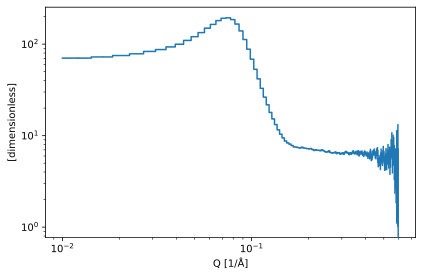

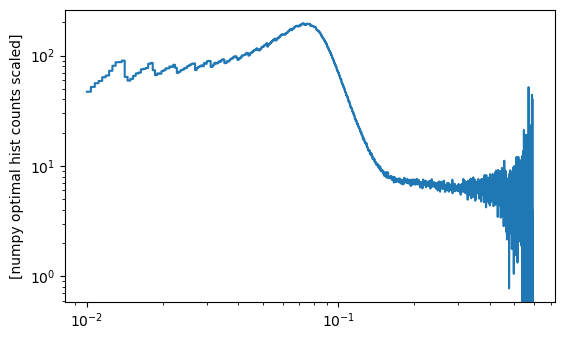

In [30]:
shst = sampres.hist()
print(shst.sizes)
print(shst)

scipp_bins = shst.coords['Q'].values
#print(scipp_bins.values)

nscipp_bins = shst.size


def optimal_linear_nbins(xevents):
    """
    Calculate optimal number of bins from Freedman-Diaconis rule
    https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
    https://en.wikipedia.org/wiki/Freedman–Diaconis_rule
    """
    xmax = np.amax(xevents)
    xmin = np.amin(xevents)

    npts = xevents.size
    
    iqr = np.subtract(*np.percentile(xevents, [75, 25]))
    return int((xmax - xmin)*npts**(1.0/3.0)/(2.0*iqr))


study_data = eventQ

opt_n_bin = optimal_linear_nbins(study_data)

event_xmax = np.amax(study_data)
event_xmin = np.amin(study_data)

slic=(event_xmax-event_xmin)/(opt_n_bin+1)
hbins = np.arange(event_xmin, event_xmax, slic)

hscale =  float(opt_n_bin) /float(nscipp_bins)

hst = np.histogram(study_data, bins=hbins, weights=eventW)
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

plt.step(x_hist, y_hist*hscale, where='post', label='Weighted')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('[numpy optimal hist counts scaled]')
plt.tight_layout()

shst.plot(scale={'Q': 'log'}, norm='log')


[[Model]]
    Model(lorg)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 159
    # data points      = 140
    # variables        = 6
    chi-square         = 881.953431
    reduced chi-square = 6.58174203
    Akaike info crit   = 269.669557
    Bayesian info crit = 287.319411
    R-squared          = 0.99687390
[[Variables]]
    aa:      2.32779433 +/- 0.48545240 (20.85%) (init = 50)
    bb:      7.61573589 +/- 0.23508477 (3.09%) (init = 50)
    kappa1:  0.10000000 +/- 2.6680e-04 (0.27%) (init = 0.05)
    kappa2:  0.01891083 +/- 3.0219e-04 (1.60%) (init = 0.05)
    q0:      0.07132956 +/- 1.8192e-04 (0.26%) (init = 0.07)
    bg:      6.34728288 +/- 0.26658620 (4.20%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(aa, kappa1)     = +0.9960
    C(aa, bb)         = -0.9631
    C(bb, kappa1)     = -0.9497
    C(bb, kappa2)     = +0.8971
    C(aa, kappa2)     = -0.8248
    C(kappa1, kappa2) = -0.8013
    C(bb, q0)         = -0.4437
    

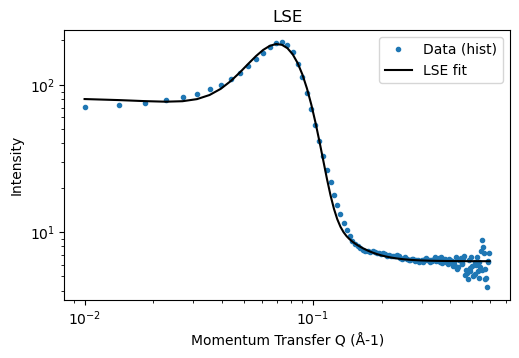

In [45]:
## Least Squares Fit of scipp histo data

from lmfit import Model

from scipy.special import erfc
from scipy.stats import cauchy
from scipy.stats import norm


def dlor(x, aa, bb, kappa1, kappa2, q0, bg):
    # Double lorentzian model
    return aa/(kappa1*kappa1 + x*x) + bb / (kappa2*kappa2 + (x-q0)**2.0) + bg

dlorm = Model(dlor)
dlorparams = dlorm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)

def lor2p(x, aa, bb, kappa1, kappa2, q0, bg1, bg2):
    # A piecewise lorentzian and lorentzian squared
    lor2 = bb/(kappa2*kappa2 + (x-q0)**2.0)**2.0
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    res = lor+bg1
    mask = np.where(x>q0)
    res[mask] = lor2[mask]+bg2
    return res

lor2pm = Model(lor2p)
lor2pparams = lor2pm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg1=dict(value=5, min=0.0, max=100.0),
    bg2=dict(value=5, min=0.0, max=100.0)
)


def lor2(x, aa, bb, kappa1, kappa2, q0, bg):
    # A shifted lorentzian and lorentzian squared
    lor2 = bb/(kappa2*kappa2 + (x-0.0)**2.0)**2.0
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    res = lor+lor2+bg
    return res

lor2m = Model(lor2)
lor2params = lor2m.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0)
)



def lorgpw(x, aa, bb, kappa1, kappa2, q0, bg1, bg2):
    # Piecewise lorentzian and gaussian with two separate bg terms
    # Best so far but complete nonsense
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    gau = bb * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)
    res = lor+bg1
    mask = np.where(x>q0)
    res[mask] = gau[mask]+bg2
    return res

lorgpwm = Model(lorgpw)

lorgpwparams = lorgpwm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg1=dict(value=5, min=0.0, max=100.0),
    bg2=dict(value=5, min=0.0, max=100.0)
)



def lorg(x, aa, bb, kappa1, kappa2, q0, bg):
    # Gaussian sitting on a lorentzian type term (powered)
    #ll = aa/(kappa1*kappa1 + x*x)**3.0
    #gg = bb * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)

    ll = aa * cauchy.pdf(x, scale=kappa1, loc=0.0)**3.0
    gg = bb * norm.pdf(x, scale=kappa2, loc=q0)
    
    return  ll + gg + bg

lorgm = Model(lorg)
lorgparams = lorgm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)



def lormodg(x, aa, bb, tau, kappa1, kappa2, q0, bg):
    # Modified Gaussian sitting on a lorentzian type term (powered)
    # See http://dx.doi.org/10.6028/jres.119.003
    # Bragg peaks are only gaussian when not sample-spread
    ll = aa/(kappa1*kappa1 + x*x)**2.0
    gg = bb * (tau/2.0) * np.exp( 0.5*tau*tau*kappa2*kappa2 + tau*(q0-x)) * erfc( - ((x-q0) / (np.sqrt(2.0)*kappa2)) + tau*kappa2 / np.sqrt(2.0))
    return  ll + gg + bg

lormodgm = Model(lormodg)
lormodgparams = lormodgm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    tau=dict(value=0.1, min=0.01, max=0.1),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)









def dg(x, aa, bb, kappa1, kappa2, q0, bg):
    # Two gaussians
    g1 = aa * (1.0 / (kappa1 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - 0.0)/kappa1)**2.0)
    g2 = bb * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)
    return  g1 + g2 + bg

dgm = Model(dg)
dgparams = dgm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)



def threec(x, aa, bb, cc, kappa1, kappa2, q0, bg):
    # Three component piecewise model with one background
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    lor2 = bb/(kappa1*kappa1 + (x-q0)**2.0)**2.0
    gau = cc * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)
    res = lor + lor2 + bg
    mask = np.where(x>q0)
    res[mask] = gau[mask] + lor2[mask] + bg
    return res

threecm = Model(threec)

threecparams = threecm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    cc=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0)
)





lmm = lorgm
params = lorgparams


result = lmm.fit(y_histw, params, x=x_histw)#, weights = 1.0/e_histw)


print(result.fit_report())

fig, ax = plt.subplots()
ax.plot(x_histw, y_histw, marker='.', ls='none', label="Data (hist)")
ax.plot(x_histw, result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('LSE')
ax.legend()

sample_lse_x = x_histw
sample_lse_pmf = result.best_fit

ax.set_xlabel('Momentum Transfer Q (Å-1)')
ax.set_ylabel('Intensity')

#plt.savefig('twocomponent-lse-fit.png', bbox_inches='tight')
plt.show()

#lsq2 = result.best_values['q2']
#lskappa = result.best_values['kappa']
#lskappae = result.result.uvars["kappa"].std_dev
#lsq0 = result.best_values['q0']
#lsq0e= result.result.uvars["q0"].std_dev

# kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

kappaSampleLSE = result.best_values['kappa1']
kappaSampleLSEe = result.result.uvars["kappa1"].std_dev
sigmaLSE = result.best_values['kappa2']
sigmaLSEe = result.result.uvars["kappa2"].std_dev
q0LSE = result.best_values['q0']
q0LSEe = result.result.uvars["q0"].std_dev
sampaaLSE = result.best_values['aa']
ggLSE = result.best_values['bb']
sampbgLSE = result.best_values['bg']


That isn't perfect but it's the best of the bunch.  Now we need a model for the background.

In [33]:
siq = pipeline.get(IofQ[SampleRun])
sres= siq.compute()
bgiq = pipeline.get(IofQ[BackgroundRun])
bgres = bgiq.compute()

An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.
An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


In [34]:
allsevents = sres.bins.concat().value
allbgevents = bgres.bins.concat().value
print(allbgevents)

<scipp.DataArray>
Dimensions: Sizes[event:99205, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.0139289, 0.0139563, ..., 0.585179, 0.591361]
* phi                       float64            [rad]  (event)  [-1.56199, -1.7183, ..., 2.36995, 2.37299]
* pulse_time              datetime64             [ns]  (event)  [2020-02-14T05:45:58.838989257, 2020-02-14T05:42:03.839019775, ..., 2020-02-14T06:05:00.837036132, 2020-02-14T05:40:45.438995361]
* tof                       float64            [µs]  (event)  [88027.7, 83397.7, ..., 12089.2, 11820.7]
* wavelength                float64             [Å]  (event)  [14.9567, 14.1702, ..., 2.04783, 2.0025]
Data:
                            float64  [dimensionless]  (event)  [0.00235922, 0.00235922, ..., 1.12811, 1.63057]  [5.94507e-06, 5.94507e-06, ..., 1.61637, 3.00454]




In [35]:
seventQ = allsevents.coords['Q'].values
seventW = allsevents.values
bgeventQ = allbgevents.coords['Q'].values
bgeventW = allbgevents.values

nans = np.isnan(bgeventW)
bgeventW[nans] = 0.0
msk = np.where(bgeventW < 0.0)
bgeventW[msk] = 0.0

nans = np.isnan(seventW)
seventW[nans] = 0.0
msk = np.where(seventW < 0.0)
seventW[msk] = 0.0


140
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [2.10442, 1.35467, ..., 0, 0]  [0.005303, 0.00203108, ..., 0, 0]




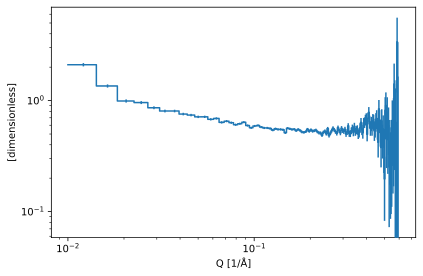

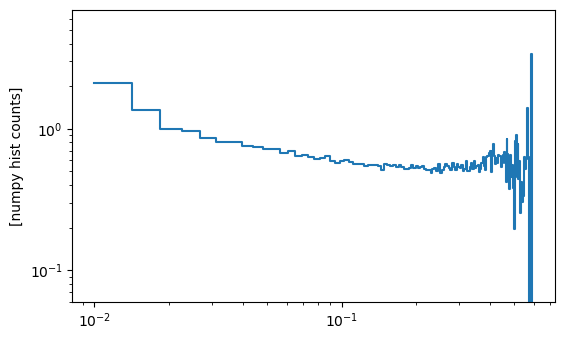

In [36]:
bghst = bgres.hist()
print(bghst.size)
print(bghst)

scipp_bgbins = bghst.coords['Q'].values
#print(scipp_bins.values)

bgnhstw = np.histogram(bgeventQ, bins=scipp_bgbins, weights=bgeventW)
x_bgnhistw = bgnhstw[1]
x_bgnhistw = x_bgnhistw[:-1]
y_bgnhistw = bgnhstw[0]


bgnhst = np.histogram(bgeventQ, bins=scipp_bgbins)#, weights=np.sqrt(eventW))
x_bgnhist= bgnhst[1]
x_bgnhist = x_bgnhist[:-1]
y_bgnhist = bgnhst[0]
e_bgnhist = np.sqrt(y_bgnhist)



scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

#plt.errorbar(x_histw, y_histw, yerr=e_histw, label='Weighted')
#plt.errorbar(x_hist, y_hist, yerr=e_hist, label='Unweighted')
plt.step(x_bgnhistw, y_bgnhistw, where='post', label='Weighted')
#plt.plot(x_hist, scl*y_hist, label=scltxt)
plt.yscale('log')
plt.xscale('log')
#plt.legend()
plt.ylim([0.06, 6.9])
plt.ylabel('[numpy hist counts]')
plt.tight_layout()

bghst.plot(scale={'Q': 'log'}, norm='log')

[[Model]]
    Model(lor)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 140
    # variables        = 3
    chi-square         = 12.3512033
    reduced chi-square = 0.09015477
    Akaike info crit   = -333.904451
    Bayesian info crit = -325.079524
    R-squared          = 0.21301925
[[Variables]]
    aa:     1.8778e-04 +/- 8.9806e-05 (47.82%) (init = 50)
    kappa:  0.00496984 +/- 0.00696854 (140.22%) (init = 0.05)
    bg:     0.57678222 +/- 0.02680457 (4.65%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(aa, kappa) = +0.9392
    C(aa, bg)    = -0.2995
    C(kappa, bg) = -0.2406


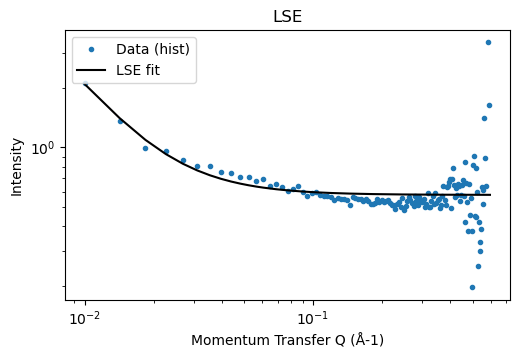

In [46]:
## Least Squares Fit of scipp histo background data

from lmfit import Model

from scipy.special import erfc


def lor(x, aa, kappa, bg):
    # Double lorentzian model
    return aa/(kappa*kappa + x*x) + bg

lorm = Model(lor)
lorparams = lorm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa=dict(value=0.05, min=0.001, max=0.1),\
    bg=dict(value=5, min=0.0, max=100.0)
)


def lor2(x, aa, bb, kappa, bg):
    # A shifted lorentzian and lorentzian squared
    lor2 = bb/(kappa*kappa + x**2.0)**2.0
    lor = aa/(kappa*kappa + x**2.0)
    res = lor+lor2+bg
    return res

lor2m = Model(lor2)
lor2params = lor2m.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa=dict(value=0.05, min=0.001, max=0.1),\
    bg=dict(value=5, min=0.0, max=100.0)
)


def expf(x, aa, kappa, bg):
    # Double lorentzian model
    return aa * np.exp(-(x/kappa)) + bg

expm = Model(expf)
expparams = expm.make_params(
    aa=dict(value=50.0, min=0.0),\
    kappa=dict(value=0.05, min=0.001, max=0.1),\
    bg=dict(value=5, min=0.0, max=100.0),
)


lmm = lorm
params = lorparams


result = lmm.fit(y_bgnhistw, params, x=x_bgnhistw)#, weights = 1.0/e_histw)


print(result.fit_report())

fig, ax = plt.subplots()
ax.plot(x_bgnhistw, y_bgnhistw, marker='.', ls='none', label="Data (hist)")
ax.plot(x_bgnhistw, result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('LSE')
ax.legend()

bg_lse_x = x_bgnhistw
bg_lse_pmf = result.best_fit

ax.set_xlabel('Momentum Transfer Q (Å-1)')
ax.set_ylabel('Intensity')

#plt.savefig('twocomponent-lse-fit.png', bbox_inches='tight')
plt.show()

#lsq2 = result.best_values['q2']
#lskappa = result.best_values['kappa']
#lskappae = result.result.uvars["kappa"].std_dev
#lsq0 = result.best_values['q0']
#lsq0e= result.result.uvars["q0"].std_dev

# kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

kappaBGLSE = result.best_values['kappa']
BGaaLSE = result.best_values['aa']
BGbgLSE = result.best_values['bg']

We now have all the weights for each term from LSE, but we need to normalise them.  The normalisation comes after the definition of log-likelihood below...

In [39]:
m0LSE = sampaaLSE
m1LSE = ggLSE 
m2LSE = BGaaLSE 
mXLSE = BGbgLSE + sampbgLSE

print(m0LSE)
print(m1LSE)
print(m2LSE)
print(mXLSE)


2.3277943261477523
7.615735893577655
0.00018778484038639576
6.9240651000724345


In [40]:
evs = np.concatenate((seventQ, bgeventQ))
wts = np.concatenate((seventW, bgeventW))

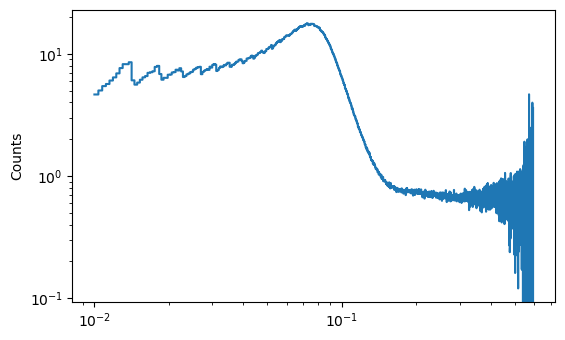

In [41]:
opt_n_bin = optimal_linear_nbins(evs)

event_xmax = np.amax(evs)
event_xmin = np.amin(evs)

slic=(event_xmax-event_xmin)/(opt_n_bin+1)
hbins = np.arange(event_xmin, event_xmax, slic)

#hscale =  float(opt_n_bin) /float(nscipp_bins)

hst = np.histogram(evs, bins=hbins, weights=wts)
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

plt.step(x_hist, y_hist, where='post', label='Weighted')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Counts')
plt.tight_layout()


In [42]:
# Build the MCMC model

import scipy.stats as spst

def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
        
    if 0.001 < kappaSample < 0.1 and\
    0.001 < sigma < 0.1 and\
    0.001 < q0 < 0.4 and\
    0.001 < kappaBG < 0.1 and\
    0.0 < m1 < 1.0 and\
    0.0 < m2 < 1.0 and\
    0.0 < m3 < 1.0 and\
    m1 + m2 + m3 < 1.0:
        return 0.0
    
    return -np.inf


def simplex_weights(Qraw):
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
                
    return Qvals



def cauchy_integral(xmin, xmax, kappa):
    # Returns the integral over the range of x values
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def cauchy_cubed_integral(xmin, xmax, kappa):
    # This derivation is copy-pasted out of mathematica...
    cdf =    -0.125*(-((kappa*(3*xmax**3 + 5*xmax*kappa**2))/ \
     -        (xmax**2 + kappa**2)**2) + \
     -     (kappa*(3*xmin**3 + 5*xmin*kappa**2))/ \
     -      (xmin**2 + kappa**2)**2 - 3*np.arctan(xmax/kappa) + \
     -     3*np.arctan(xmin/kappa))/(np.pi**3*kappa**2)
    return cdf
    


def uniform_integral(x1, x2):
    # Returns the integral over the range of x values
    # Assume y=1 over the range

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    intg = spst.norm.cdf(x1, loc=mu, scale=sigma) - spst.norm.cdf(x2, loc=mu, scale=sigma)
    
    return np.absolute(intg)


def pmf(xx, theta, pweights=None,  verbose=False):
    
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = study_xmax-study_xmin

    
    sig_int = cauchy_cubed_integral(study_xmin, study_xmax, kappaSample)
    bg_int = cauchy_integral(study_xmin, study_xmax, kappaBG)
    gauss_int = gaussian_integral(study_xmin, study_xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(study_xmin, study_xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    
    
    signal = spst.cauchy.pdf(xx, loc=0.0, scale = kappaSample)**3.0
    background = spst.cauchy.pdf(xx, loc=0.0, scale = kappaBG)
    gauss = spst.norm.pdf(xx, loc=q0, scale = sigma)
    uniform = spst.uniform.pdf(xx, loc=study_xmin, scale = study_xmax)
    
    term1 = mvals[0] * signal / sig_int
    term2 = mvals[1] * background / bg_int
    term3 = mvals[2] * gauss / gauss_int
    term4 = mvals[3] * uniform / uniform_int
    
            
    if verbose:
        print("xmin:", study_xmin)
        print("xmax:", study_xmax)
        print("Signal:", signal)
        print("Background:", background)
        print("Gauss:", gauss)
        print("Gauss:", gauss)
        print("sig_int:", sig_int)
        print("bg_int:", bg_int)
        print("mvals:", mvals)
    
    result = (term1 + term2 + term3 + term4)**use_weights
    
    return result




def log_likelihood(theta):
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    sig_int = cauchy_cubed_integral(study_xmin, study_xmax, kappaSample)
    bg_int = cauchy_integral(study_xmin, study_xmax, kappaBG)
    gauss_int = gaussian_integral(study_xmin, study_xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(study_xmin, study_xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    

    signal = mvals[0]*spst.cauchy.pdf(study_data, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = mvals[1]*spst.cauchy.pdf(study_data, loc=0.0, scale = kappaBG) / bg_int
    gauss = mvals[2]*spst.norm.pdf(study_data, loc=q0, scale = sigma) / gauss_int
    uniform = mvals[3]*spst.uniform.pdf(study_data, loc=study_xmin, scale = study_xmax) / uniform_int

    

    ll = np.log(signal)
    lbg = np.log(background)
    lgauss = np.log(gauss)
    lunif = np.log(uniform)

    # logaddexp is used to add the two components in linear space
    # in theory I suppose you can do it before taking the log above...
    ll1 = np.logaddexp(ll, lbg)
    ll2 = np.logaddexp(ll1, lunif)
    ll3 = np.logaddexp(ll2, lgauss)
    ll4 = np.sum(ll3 * study_weights)
        
    result = lp + ll4
    
    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        
    return result




# Make some unit tests of the code for consistency

def unit_tests():
    print("Unit testing code...")
         # kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
    pt = np.array([0.01, 0.01, 0.2, 0.008,  0.2, 0.2, 0.2])
    testpmf = pmf(study_data, pt, study_weights)


    # Check the CDF values for cauchy distribution
    cauchy_cdf_mathematica_check = cauchy_integral(0.001, 0.002, 0.01)
    assert np.isclose(cauchy_cdf_mathematica_check, 0.0311074), f"Inconsistency between cauchy cdf and analytical {cauchy_cdf_mathematica_check, 0.0311074}"
    print("\tCauchy CDF pass")

    # Check the CDF values for the gaussian distribution
    gauss_cdf_mathematica_check = gaussian_integral(0.001, 0.002, 0.001, 0.001)
    assert np.isclose(gauss_cdf_mathematica_check, 0.341345), f"Inconsistency between cauchy cdf and analytical {cauchy_cdf_mathematica_check, 0.341345}"
    print("\tGaussian CDF pass")


    
    # Check the consistency between log(pdf) and log likelihood for two data points 
    ll = log_likelihood(pt)
    lp = log_prior(pt)
    sumll = lp + np.sum(np.log(testpmf))
    assert np.isclose(sumll, ll), f"Inconsistency between sum log pmf and log_likelihood {sumll, ll}"
    print("\tLikelihood pass")
    
    
    print("Unit testing complete.")


testx = np.array([0.001, 0.1])
test_weights = np.array([0.8, 0.8])
study_data = testx
study_weights = test_weights

study_xmin=np.amin(study_data)
study_xmax=np.amax(study_data)

unit_tests()



Unit testing code...
	Cauchy CDF pass
	Gaussian CDF pass
	Likelihood pass
Unit testing complete.


In [43]:
study_data = evs

study_xmin=np.amin(study_data)
study_xmax=np.amax(study_data)

print("Raw LSE weights")

m0LSE = sampaaLSE
m1LSE = BGaaLSE 
m2LSE = ggLSE 
mXLSE = BGbgLSE + sampbgLSE

print(m0LSE)
print(m1LSE)
print(m2LSE)
print(mXLSE)

# Qraw = np.asarray(Qraw)
# Qsum = np.sum(Qraw)    
# Qlast = 1.0 - Qsum
# Qvals = np.append(Qraw, Qlast)
 

def unsimplex(mvalues):
    # The opposite of the simplex weight function above
    # The incoming mvalues are not normalised, unlike the simplex weight function output
    msum = np.sum(mvalues)
    mvalues = mvalues / msum # now they sum to 1
    m3 = np.take(mvalues, [0, 1, 2])
    return m3

    

print("\nAmplitude Values")
print(m0LSE)
print(m1LSE)
print(m2LSE)
print(mXLSE)

mLSE = unsimplex(np.array([m0LSE, m1LSE, m2LSE, mXLSE]))

sig_int_LSE = cauchy_cubed_integral(study_xmin, study_xmax, kappaSampleLSE)
gauss_int_LSE = gaussian_integral(study_xmin, study_xmax, mu=q0LSE, sigma=sigmaLSE)
bg_int_LSE = cauchy_integral(study_xmin, study_xmax, kappaBGLSE)
uniform_int_LSE = uniform_integral(study_xmin, study_xmax)

print("\nIntegrals")
print(sig_int_LSE)
print(bg_int_LSE)
print(gauss_int_LSE)
print(uniform_int_LSE)

m0LSEr = sampaaLSE / sig_int_LSE
m1LSEr = BGaaLSE / bg_int_LSE
m2LSEr = ggLSE / gauss_int_LSE
mXLSEr = (BGbgLSE + sampbgLSE) /uniform_int_LSE

print("\nCurve Weights")
print(m0LSEr)
print(m1LSEr)
print(m2LSEr)
print(mXLSEr)

print("\nNormalised Curve Weights")
m0LSE = m0LSEr/mXLSEr
m1LSE = m1LSEr/mXLSEr
m2LSE = m2LSEr/mXLSEr

mLSEsum = m0LSE + m1LSE + m2LSE

m0LSE = m0LSE/mLSEsum
m1LSE = m1LSE/mLSEsum
m2LSE = m2LSE/mLSEsum

print(m0LSE)
print(m1LSE)
print(m2LSE)

print("Sum = ", m0LSE + m1LSE + m2LSE)


Raw LSE weights
2.3277943261477523
0.00018778484038639576
7.615735893577655
6.9240651000724345

Amplitude Values
2.3277943261477523
0.00018778484038639576
7.615735893577655
6.9240651000724345

Integrals
1.4183024823801005
0.14415212437383082
0.9994087985644087
0.5841878470931993

Curve Weights
1.6412537911104854
0.0013026852098232827
7.620240990991081
11.852463440527194

Normalised Curve Weights
0.17718770132916165
0.00014063626182268227
0.8226716624090158
Sum =  1.0


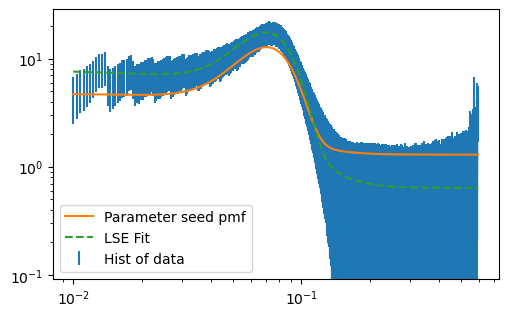

In [63]:
study_data = evs

study_xmin=np.amin(study_data)
study_xmax=np.amax(study_data)

nbins = optimal_linear_nbins(study_data)

slic=(study_xmax-study_xmin)/(nbins+1)

hbins = np.arange(study_xmin, study_xmax, slic)


hst = np.histogram(study_data, bins=hbins, weights=wts)
x_hist = hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

#       kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
# seed values taken roughly from LSE above
#theta_seed = 0.1, 0.015, 0.07, 0.01, 0.1, 0.1, 0.3
# m1 => signal
# m2 => background
# m3 => uniform
# m4 => gauss

#theta_seed = kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, 0.4, 0.005, 0.1
theta_seed = kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, mLSE[0], mLSE[1], mLSE[2]

y_line = pmf(x_hist, theta_seed)
    #porod_pmf(x_hist, alpha=4.0, xmin=x_hist[0])
#y_int = porodobj.cdf(x=np.amax(x_hist), xmin=0.001, alpha=porod_alpha)
#print(y_int)

lse_pmf = sample_lse_pmf + bg_lse_pmf

lsesum = np.sum(lse_pmf)

lsum = np.sum(y_line)
hsum = np.sum(y_hist)

yscale = hsum / lsum

y_line = y_line * yscale

lsescale = (hsum/lsesum) * (sample_lse_x.size/x_hist.size)
lse_pmf_scaled = lse_pmf * lsescale

plt.errorbar(x_hist, y_hist, yerr=e_hist, ls='None', marker='None', label='Hist of data')
plt.plot(x_hist, y_line, label='Parameter seed pmf')
plt.plot(sample_lse_x, lse_pmf_scaled, ls='--', label='LSE Fit')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [58]:
print(x_hist.size)
print(sample_lse_x.size)

1551
140


In [24]:
# subsample for speed

subsample_size=80000
nevents = evs.size

rng = np.random.default_rng()
elements = rng.choice(nevents, subsample_size)

subsample = evs[elements]
subweights = wts[elements]
print(subsample.shape)
print(subweights.shape)

(80000,)
(80000,)


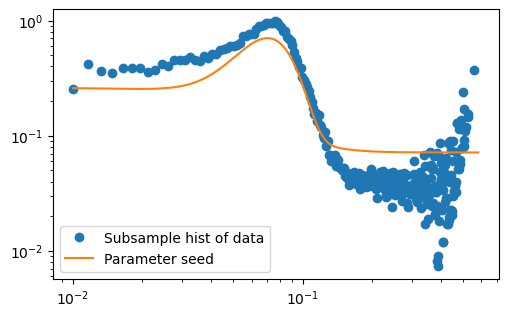

In [59]:
event_xmin = np.amin(subsample)
event_xmax = np.amax(subsample)

nbins = optimal_linear_nbins(subsample)

slic=(event_xmax-event_xmin)/(nbins+1)

hbins = np.arange(event_xmin, event_xmax, slic)


hst = np.histogram(subsample, bins=hbins, weights=subweights)
x_hist = hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

#       kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
# seed values taken roughly from LSE above
theta_seed = kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, mLSE[0], mLSE[1], mLSE[2]

y_line = pmf(x_hist, theta_seed)
    #porod_pmf(x_hist, alpha=4.0, xmin=x_hist[0])
#y_int = porodobj.cdf(x=np.amax(x_hist), xmin=0.001, alpha=porod_alpha)
#print(y_int)

lsum = np.sum(y_line)
hsum = np.sum(y_hist)

yscale = hsum / lsum

y_line = y_line * yscale


plt.plot(x_hist, y_hist, ls='None', marker='o', label='Subsample hist of data')
plt.plot(x_hist, y_line, label='Parameter seed')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [25]:
study_data = subsample
study_weights = subweights

import emcee

ndim, nwalkers = 7, 32

p0 = theta_seed
p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location
print("Burn in:")
state = sampler.run_mcmc(p0, 400, progress=True)

# Run the production chain.
sampler.reset()
print("Sampling:")
sampler.run_mcmc(state, 200, progress=True);

Burn in:


  0%|                                                   | 0/400 [00:00<?, ?it/s]/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  5%|█▉                                        | 19/400 [00:02<01:00,  6.27it/s]/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_3209/3226276111.py:155: RuntimeWarning: divide by zero encountered in log
  lgauss = np.log(gauss)
100%|█████████████████████████████████████████| 400/400 [01:06<00:00,  5.98it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  6.01it/s]


In [ ]:
# Ouch that is slow for the full data
# 16 seconds per iteration on a 2022 MBP (M1)
# Still, it's a big-ish data set so I used subsampling to get it down just for testing
# That makes almost 2 hours for 200 point burn in plus 200 point sampling.
# It's almost like working on monte-carlo again.
# However, it's running on only one core, can probably multi-core it to get it down to < 0.5 hrs.

320
[0.0683259  0.01322311 0.07924638 0.02505422 0.1925701  0.11542255
 0.20456401]


Text(0.5, 0, 'Q (Å-1)')

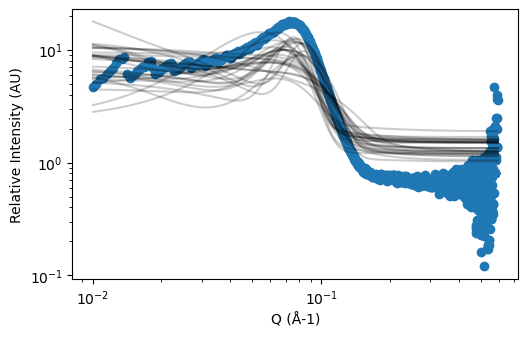

In [26]:
# Population based fit of the data

flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)

print(len(flat_samples))

inds = np.random.randint(len(flat_samples), size=30)

pt_sum = np.sum(y_hist)

xfit_min = np.amin(study_data)
xfit_max = np.amax(study_data)

x_fit = np.linspace(xfit_min, xfit_max, 1000)

fig, ax = plt.subplots()


for ind in inds:
    sample = flat_samples[ind]
    y_fit = pmf(x_fit, sample)
    #pt_sum = np.sum(y_fit)
    y_check = pmf(x_hist, sample)
    ysum = np.sum(y_check)
    scale = pt_sum / ysum
    y_fit = y_fit * scale
    if ind == inds[0]:
        print(sample)

    ax.plot(x_fit, y_fit, color='black', alpha = 0.2)# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
ax.scatter(x_hist, y_hist)#, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
#cbar = fig.colorbar(sct)
#cbar.ax.set_ylabel('Point Signal Weight')




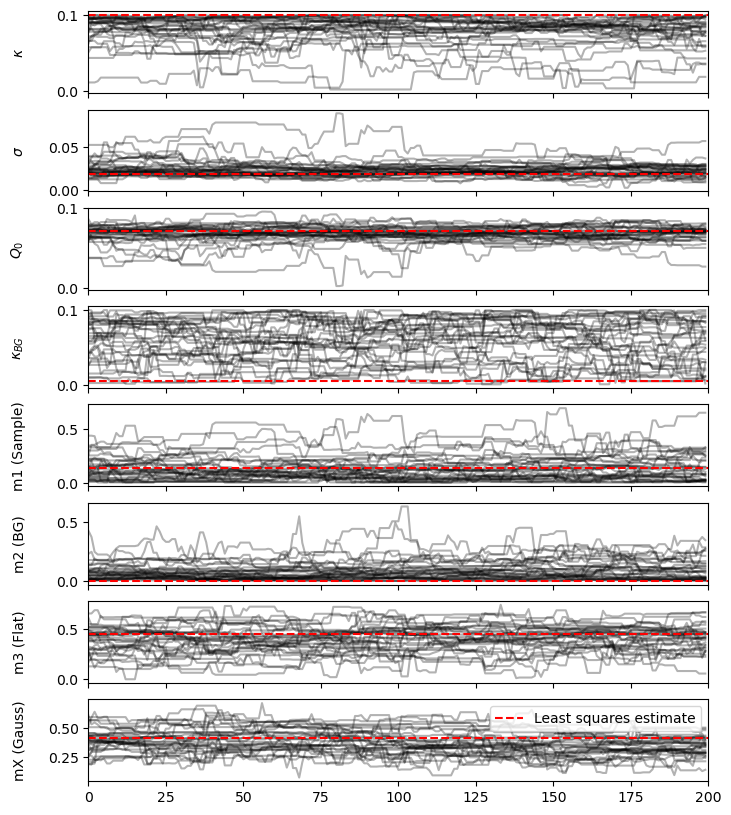

In [65]:
# Plot the theta curves during sampling 
fig, axes = plt.subplots(ndim+1, figsize=(8, 10), sharex=True)
samples = sampler.get_chain()

mX = 1.0 - samples[:,:,4] - samples[:,:,5] - samples[:,:,6]

#       kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
labels = ["$\kappa$", "$\sigma$", "$Q_0$", "$\kappa_{BG}$", "m1 (Sample)", "m2 (BG)", "m3 (Flat)"]
lsvals=np.array([kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, mLSE[0], mLSE[1], mLSE[2]])
#truevals=np.array([true_kappa, np.log10(porod_events.size / (porod_events.size + curv.data.size))])
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.hlines(lsvals[i], 0, samples[:,:,i].size, color='r', ls='--', label='Least squares estimate')
    #ax.hlines(truevals[i], 0, samples[:,:,i].size, color='g', ls='-', label='True value')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

ax = axes[7]
ax.plot(mX, "k", alpha=0.3)
ax.set_ylabel("mX (Gauss)")
ax.hlines(1.0-mLSE[0]-mLSE[1]-mLSE[2], 0, samples[:,:,i].size, color='r', ls='--', label='Least squares estimate')
ax.set_xlim(0, len(samples))
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.legend()


plt.savefig('MCMC-samples.png', bbox_inches='tight')
plt.show()

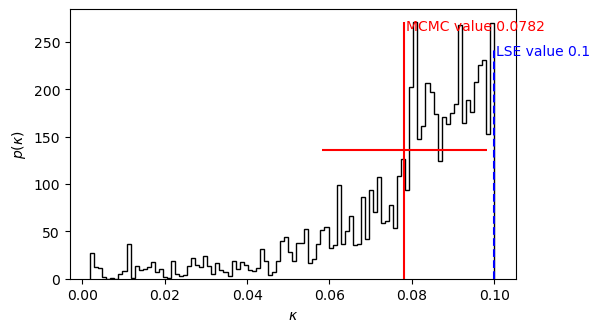

Acceptance fraction is possibly low: 0.32484375 (should be at high end of range 0.0--1.0)
kappa estimate       : 0.07821375990688227
kappa std.dev.       : 0.020093371742976016


In [89]:
samples=sampler.get_chain(flat=True)

kappa_mean = np.mean(samples[:,0])
kappa_stddev = np.std(samples[:,0])

barmin = kappa_mean - kappa_stddev
barmax = kappa_mean + kappa_stddev



lstxt   = "LSE value " + str(round(kappaSampleLSE,4))
fittxt = "MCMC value " + str(round(kappa_mean,4))

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("$\kappa$")
plt.ylabel("$p(\kappa)$")
#plt.vlines(true_kappa, 0, ytop*0.8, color='g')
plt.vlines(kappaSampleLSE, 0, ytop*0.9, ls='--', color='b')
plt.vlines(kappa_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.9*0.5, xmin=kappaSampleLSE-kappaSampleLSEe, xmax=kappaSampleLSE+kappaSampleLSEe, ls='--', color='b')
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
#plt.text(true_kappa*1.005, ytop*0.77, truetxt, color="g")
plt.text(kappaSampleLSE*1.005, ytop*0.87, lstxt, color="b")
plt.text(kappa_mean*1.005, ytop*0.97, fittxt, color="red")

plt.savefig('kappa-distribution.png', bbox_inches='tight')
plt.show()

# Get quality of fit statistic from sampler
afrac = np.mean(sampler.acceptance_fraction)


introtxt = ""
if afrac < 0.6:
    introtxt = "is possibly low:"

print("Acceptance fraction", introtxt, np.mean(sampler.acceptance_fraction), "(should be at high end of range 0.0--1.0)")

print("kappa estimate       :", kappa_mean)#, " (true value =", true_kappa,")")
print("kappa std.dev.       :", kappa_stddev)

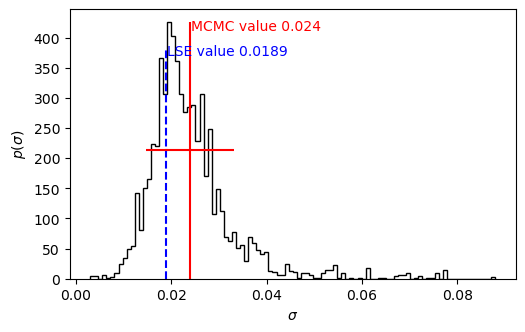

In [86]:
sigma_mean = np.mean(samples[:,1])
sigma_stddev = np.std(samples[:,1])

barmin = sigma_mean - sigma_stddev
barmax = sigma_mean + sigma_stddev



lstxt   = "LSE value " + str(round(sigmaLSE,4))
fittxt = "MCMC value " + str(round(sigma_mean,4))

hst=plt.hist(samples[:,1], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
#plt.vlines(true_kappa, 0, ytop*0.8, color='g')
plt.vlines(sigmaLSE, 0, ytop*0.9, ls='--', color='b')
plt.vlines(sigma_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.9*0.5, xmin=sigmaLSE-sigmaLSEe, xmax=sigmaLSE+sigmaLSEe, ls='--', color='b')
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
#plt.text(true_kappa*1.005, ytop*0.77, truetxt, color="g")
plt.text(sigmaLSE*1.005, ytop*0.87, lstxt, color="b")
plt.text(sigma_mean*1.005, ytop*0.97, fittxt, color="red")

plt.savefig('sigma-distribution.png', bbox_inches='tight')
plt.show()

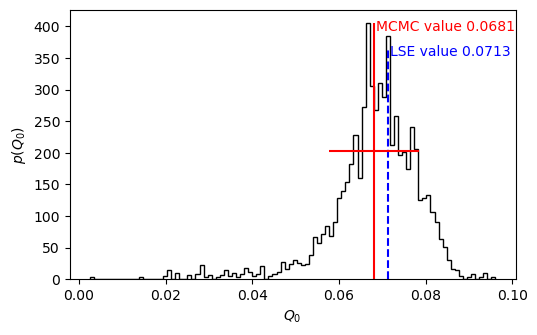

In [90]:
q0_mean = np.mean(samples[:,2])
q0_stddev = np.std(samples[:,2])

barmin = q0_mean - q0_stddev
barmax = q0_mean + q0_stddev



lstxt   = "LSE value " + str(round(q0LSE,4))
fittxt = "MCMC value " + str(round(q0_mean,4))

hst=plt.hist(samples[:,2], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("$Q_0$")
plt.ylabel("$p(Q_0)$")
#plt.vlines(true_kappa, 0, ytop*0.8, color='g')
plt.vlines(q0LSE, 0, ytop*0.9, ls='--', color='b')
plt.vlines(q0_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.9*0.5, xmin=q0LSE-q0LSEe, xmax=q0LSE+q0LSEe, ls='--', color='b')
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
#plt.text(true_kappa*1.005, ytop*0.77, truetxt, color="g")
plt.text(q0LSE*1.005, ytop*0.87, lstxt, color="b")
plt.text(q0_mean*1.005, ytop*0.97, fittxt, color="red")

plt.savefig('q0-distribution.png', bbox_inches='tight')
plt.show()